In [ ]:
pip install pyballmapper

In [ ]:
pip install kmapper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kmapper as km
import pyballmapper as pbm
import statistics
import seaborn as sns
import statsmodels.api as sm
from matplotlib.colors import ListedColormap
from matplotlib import colormaps as cm
import networkx as nx
hsvp = cm.get_cmap("gist_rainbow")

1. Upload data

In [ ]:
deprivation_data = pd.read_csv('/content/nomis_TS011.csv')
language_data = pd.read_csv('/content/nomis_profeciency english.csv')
eth_data = pd.read_csv('/content/nomis_eth_1.csv')

2. Convert data from object to float

In [ ]:
columns_to_convert = ['dep_total_households', 'dep_none', 'dep_one','dep_two']
deprivation_data[columns_to_convert] = deprivation_data[columns_to_convert].replace(',', '', regex=True).astype(float)

In [ ]:
columns_to_convert = ['langu_total_3years_older','main_english',
                     'main_not_english','english_very_well','english_well','english_not_well']
language_data[columns_to_convert] = language_data[columns_to_convert].replace(',', '', regex=True).astype(float)


In [ ]:
columns_to_convert = ['All_residents','Asian_AsianUK',
                     'Black_BlackUK','Mixed','White','Other_eth',
                     ]
eth_data[columns_to_convert] = eth_data[columns_to_convert].replace(',', '', regex=True).astype(float)

3. Merge some columns

In [ ]:
eth_data['minority'] = eth_data['Asian_AsianUK'] + eth_data['Black_BlackUK'] + eth_data['Mixed'] + eth_data['Other_eth']
eth_data['minorityP'] = eth_data['Asian_AsianUKP'] + eth_data['Black_BlackUKP'] + eth_data['MixedP'] + eth_data['Other_ethP']


In [ ]:
# Merge each dataset with deprivation
merged_lan = pd.merge(deprivation_data, language_data, on=['wardcode', 'ward'])
merged_eth = pd.merge(deprivation_data, eth_data, on=['wardcode', 'ward'])

# Merge all datasets to one
merged_all = pd.merge(merged_lan, eth_data, on=['wardcode', 'ward'])


In [ ]:
merged_all.head()

,ward,wardcode,dep_total_households,dep_total_householdsP,dep_none,dep_noneP,dep_one,dep_onep,dep_two,dep_twoP,...,Black_BlackUK,Black_BlackUKP,Mixed,MixedP,White,WhiteP,Other_eth,Other_ethP,minority,minorityP
0,Astley Bridge,E05000650,"5,962",100.0,"2,956",49.6,"1,990",33.4,837,14.0,...,207.0,1.5,295.0,2.1,11073.0,78.3,138.0,1.0,3066.0,21.8
1,Bradshaw,E05000651,"4,950",100.0,"2,502",50.5,"1,665",33.6,628,12.7,...,155.0,1.3,355.0,3.1,10800.0,93.6,69.0,0.6,738.0,6.4
2,Breightmet,E05000652,"6,011",100.0,"2,195",36.5,"2,118",35.2,"1,224",20.4,...,573.0,4.0,340.0,2.4,12823.0,89.1,148.0,1.0,1570.0,10.9
3,Bromley Cross,E05000653,"5,962",100.0,"3,483",58.4,"1,848",31.0,548,9.2,...,32.0,0.2,233.0,1.7,13110.0,96.1,47.0,0.3,535.0,3.8
4,Crompton (Bolton),E05000654,"6,749",100.0,"2,523",37.4,"2,326",34.5,"1,376",20.4,...,922.0,5.2,446.0,2.5,8623.0,49.0,408.0,2.3,8962.0,50.9


4. Create 2 new datasets dividing merged all in percentage and counted values

In [ ]:
# Create a list of columns ending with 'P'
selected_columns = [col for col in merged_all.columns if col.endswith('P')]

# Add 'ward' and 'wardcode' to the list of selected columns
selected_columns.extend(['ward', 'wardcode'])

# Create a new DataFrame only percentage
merged_allP = merged_all[selected_columns].copy()

# Create a list of columns that do NOT end with 'P'
selected_columns = [col for col in merged_all.columns if not col.endswith('P') or col in ['ward', 'wardcode']]

# Create a new DataFrame only numbers
merged_all_1 = merged_all[selected_columns].copy()

## Summary Statistics

In [ ]:
merged_allP.describe()

,dep_total_householdsP,dep_noneP,dep_twoP,dep_threeP,dep_fourP,langu_total_3years_olderP,main_englishP,main_not_englishP,english_very_wellP,english_wellP,english_not_wellP,english_not_zeroP,All_residentsP,Asian_AsianUKP,Black_BlackUKP,MixedP,WhiteP,Other_ethP,minorityP
count,297.0,297.000000,297.000000,297.000000,297.000000,297.0,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.0,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,100.0,45.215152,16.291246,5.105724,0.261953,100.0,92.280471,7.719529,3.014478,2.818519,1.584512,0.302357,100.0,9.849158,3.290236,2.694949,82.243098,1.926599,17.760943
std,0.0,8.816838,4.613793,2.672634,0.190838,0.0,7.429203,7.429203,2.672715,2.849910,1.885371,0.406153,0.0,13.236518,4.607794,1.419510,17.903026,2.157983,17.899410
min,100.0,23.500000,4.300000,0.700000,0.000000,100.0,66.200000,0.500000,0.300000,0.200000,0.100000,0.000000,100.0,0.500000,0.200000,0.800000,16.500000,0.100000,1.900000
25%,100.0,38.600000,13.000000,3.000000,0.100000,100.0,90.200000,2.400000,1.100000,0.900000,0.400000,0.100000,100.0,2.200000,0.700000,1.700000,77.100000,0.500000,5.300000
50%,100.0,44.900000,16.100000,4.700000,0.200000,100.0,95.100000,4.900000,2.100000,1.800000,0.900000,0.100000,100.0,4.500000,1.500000,2.400000,89.100000,1.000000,10.900000
75%,100.0,51.000000,19.900000,6.800000,0.400000,100.0,97.600000,9.800000,4.200000,3.500000,1.900000,0.400000,100.0,11.500000,4.000000,3.200000,94.800000,2.600000,22.900000
max,100.0,70.300000,27.900000,12.700000,0.900000,100.0,99.500000,33.800000,14.600000,13.500000,10.400000,2.600000,100.0,72.300000,33.800000,9.000000,98.200000,14.400000,83.400000


## Correlation matrix

In [ ]:
merged_all_1.corr()
#Ensure that your selection does not have any correlations greater than 0.7 in absolute value


ValueError: could not convert string to float: 'Astley Bridge'

Create dummies to creath depth to the analysis

In [ ]:
#low deprivation neighbourhood as one in which the proportion of
#households who are not considered deprived on any one of the four measures is greater than 50%.
merged_all['NoDepr_above50'] = (merged_all['dep_noneP'] > 50)*1
#households who are deprived on all four dimensions is greater than the average
merged_all['Most_Depr'] = (merged_all['dep_four'] > merged_all['dep_four'].mean())*1

Select the most relevant variables based on literature

In [ ]:
df1 = merged_all[['dep_noneP', 'dep_fourP','Most_Depr',
                   'main_not_englishP','minorityP']]

In [ ]:
df1.describe()

,dep_noneP,dep_fourP,Most_Depr,main_not_englishP,minorityP
count,297.000000,297.000000,297.000000,297.000000,297.000000
mean,45.215152,0.261953,0.383838,7.719529,17.760943
std,8.816838,0.190838,0.487140,7.429203,17.899410
min,23.500000,0.000000,0.000000,0.500000,1.900000
25%,38.600000,0.100000,0.000000,2.400000,5.300000
50%,44.900000,0.200000,0.000000,4.900000,10.900000
75%,51.000000,0.400000,1.000000,9.800000,22.900000
max,70.300000,0.900000,1.000000,33.800000,83.400000


In [ ]:
df1.corr()

,dep_noneP,dep_fourP,Most_Depr,main_not_englishP,minorityP
dep_noneP,1.000000,-0.776070,-0.647532,-0.435202,-0.378538
dep_fourP,-0.776070,1.000000,0.793579,0.604775,0.539202
Most_Depr,-0.647532,0.793579,1.000000,0.507610,0.408199
main_not_englishP,-0.435202,0.604775,0.507610,1.000000,0.922999
minorityP,-0.378538,0.539202,0.408199,0.922999,1.000000


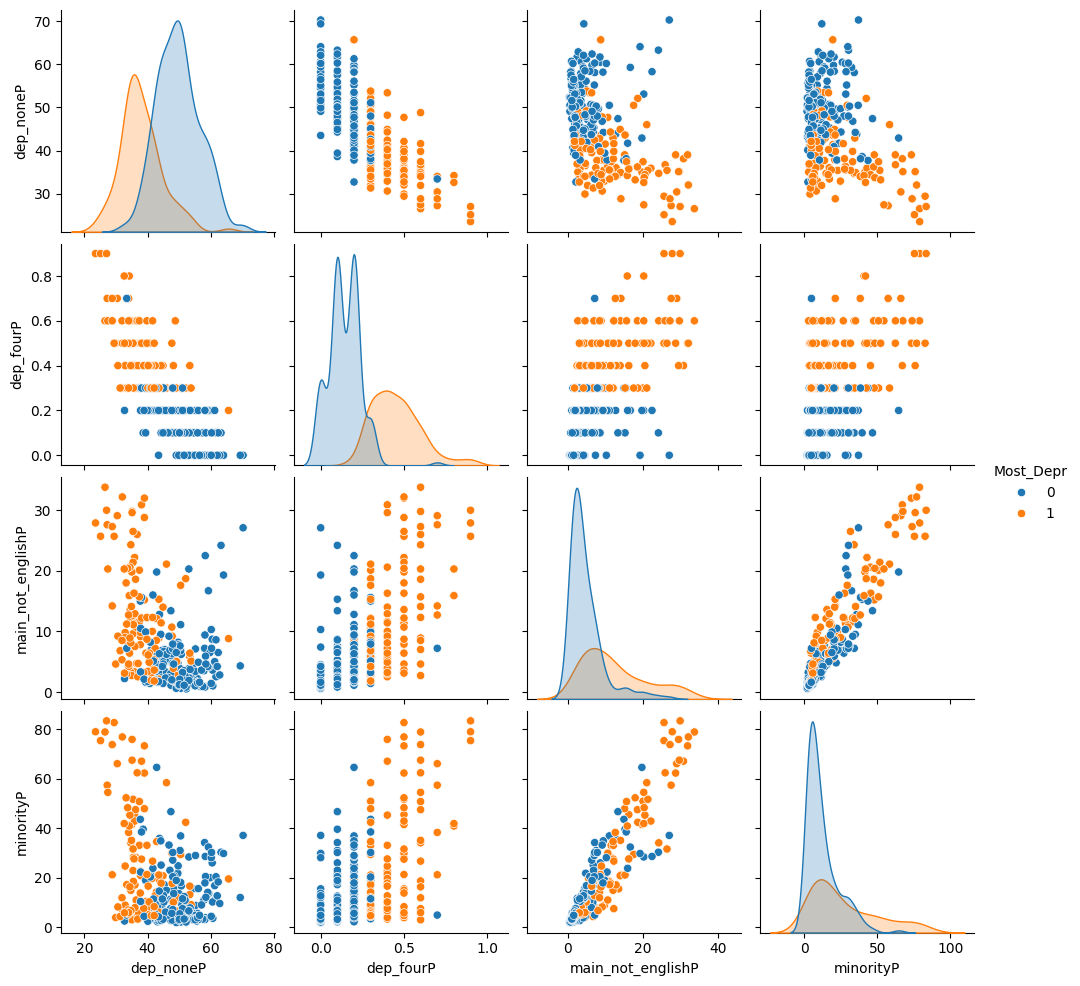

In [ ]:
sns.pairplot(df1, hue='Most_Depr')

## Language and Education Ethnicity

Higher levels of deprivation have been linked to language barriers in accessing essential services, such as healthcare, education and welfare services, exacerbating economic and social disparities between areas. Aoki and Santiago (2018)

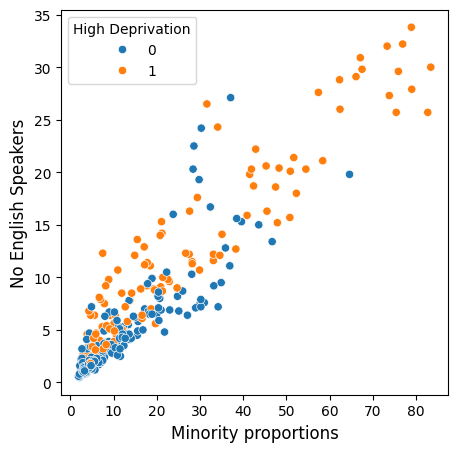

In [ ]:
fig, ax = plt.subplots(figsize = ( 5 , 5 ))

# Plot the scatterplot
sns.scatterplot( ax = ax , x = 'minorityP' , y = 'main_not_englishP' , data = df1, hue = 'Most_Depr'  )

# Set label for x-axis
ax.set_xlabel( "Minority proportions" , size = 12 )

# Set label for y-axis
ax.set_ylabel( "No English Speakers" , size = 12 )

# Set title for the legend
ax.legend(title='High Deprivation')

# Display figure
plt.show()

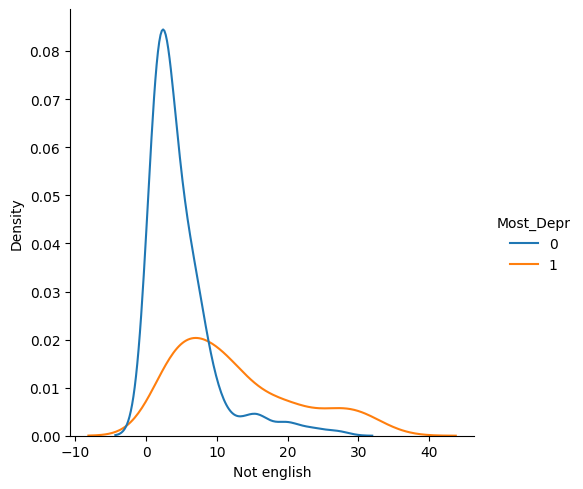

In [ ]:
ax = sns.displot(df1, x='main_not_englishP',hue="Most_Depr", kind="kde")
ax.set(xlabel='Not english', ylabel='Density')
plt.show()

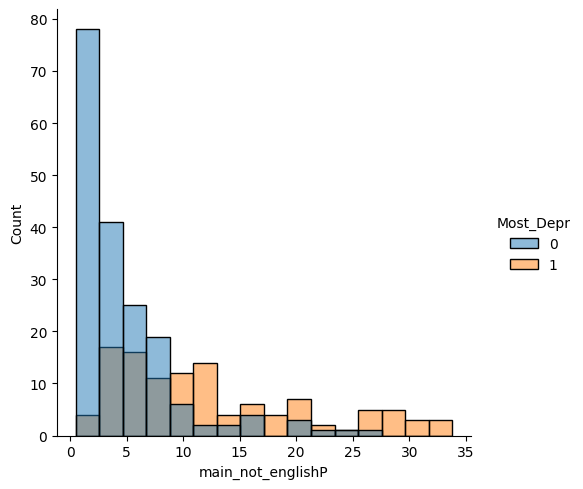

In [ ]:
sns.displot(df1, x='main_not_englishP',hue='Most_Depr')

## OLS

In [ ]:
cdf = pd.DataFrame(df1['dep_noneP'])
adf = pd.DataFrame(df1[['main_not_englishP','minorityP']])
xdf = sm.add_constant(adf)

results = sm.OLS(cdf,xdf).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              dep_noneP   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     35.16
Date:                Thu, 11 Apr 2024   Prob (F-statistic):           2.04e-14
Time:                        14:42:34   Log-Likelihood:                -1035.5
No. Observations:                 297   AIC:                             2077.
Df Residuals:                     294   BIC:                             2088.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                49.1564      0.66

This is the table of variance inflation factors. The value of no_qualifP is too high which is over 10. And it is obvious that "no_qualifP" and "level4P" are from the same census question.So I think we may need to change it to other varible.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.Series([variance_inflation_factor(xdf,i) for i in range(xdf.shape[1])],index=xdf.columns)

In [ ]:
df1['predictions'] = results.fittedvalues
df1['residuals']=df1['dep_noneP']-df1['predictions']

**Ball** **mapper**

We can set the seed=1 and k=0.5

In [ ]:
bm1.draw_networkx(coloring_variable='dep_noneP', color_palette=hsvp, colorbar=True, colorbar_label="Deprivation 0 %", pos=nx.spring_layout(bm1.Graph, k=0.5, seed=1))

This shows the predictions in of dep_noonep. We will compare it to the true value.

In [ ]:
cdf = pd.DataFrame(df1['predictions'])

bm1=pbm.BallMapper(X=adf, eps=15, coloring_df=cdf)

bm1.draw_networkx(coloring_variable='predictions', color_palette=hsvp, colorbar=True, colorbar_label="Deprivation 0 %", pos=nx.spring_layout(bm1.Graph, k=0.5, seed=1))

This shows the residuals of true value and predictions

In [ ]:
cdf = pd.DataFrame(df1['residuals'])

bm1=pbm.BallMapper(X=adf, eps=15, coloring_df=cdf)

bm1.draw_networkx(coloring_variable='residuals', color_palette=hsvp, colorbar=True, colorbar_label="Deprivation 0 %", pos=nx.spring_layout(bm1.Graph, k=0.5, seed=1))

In [ ]:
cdf = pd.DataFrame(df1['no_qualifP'])

bm1=pbm.BallMapper(X=adf, eps=15, coloring_df=cdf)

bm1.draw_networkx(coloring_variable='no_qualifP', color_palette=hsvp, colorbar=True, colorbar_label="No Qualification %", pos=nx.spring_layout(bm1.Graph, k=0.5, seed=1))

In [ ]:
cdf = pd.DataFrame(df1['level4_qualifP'])

bm1=pbm.BallMapper(X=adf, eps=15, coloring_df=cdf)

bm1.draw_networkx(coloring_variable='level4_qualifP', color_palette=hsvp, colorbar=True, colorbar_label="Level4 Qualification %", pos=nx.spring_layout(bm1.Graph, k=0.5, seed=1))

<Axes: >

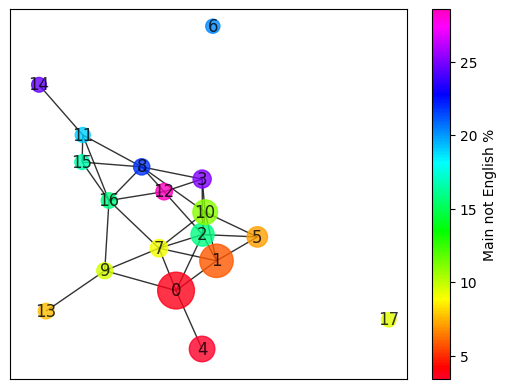

In [ ]:
cdf = pd.DataFrame(df1['main_not_englishP'])

bm1=pbm.BallMapper(X=adf, eps=15, coloring_df=cdf)

bm1.draw_networkx(coloring_variable='main_not_englishP', color_palette=hsvp, colorbar=True, colorbar_label="Main not English %", pos=nx.spring_layout(bm1.Graph, k=0.5, seed=1))

<Axes: >

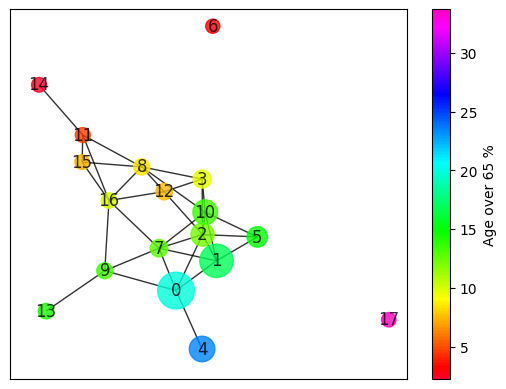

In [ ]:
cdf = pd.DataFrame(df1['65_overP'])

bm1=pbm.BallMapper(X=adf, eps=15, coloring_df=cdf)

bm1.draw_networkx(coloring_variable='65_overP', color_palette=hsvp, colorbar=True, colorbar_label="Age over 65 %", pos=nx.spring_layout(bm1.Graph, k=0.5, seed=1))

<Axes: >

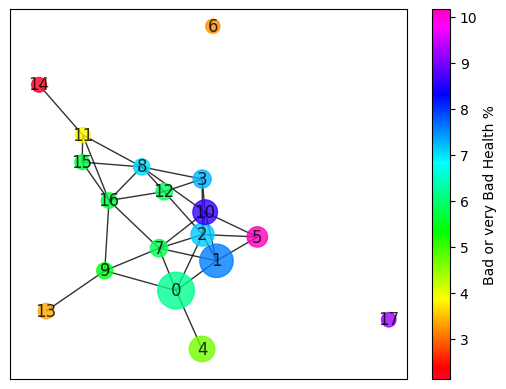

In [ ]:
cdf = pd.DataFrame(df1['h_bad_verybadP'])

bm1=pbm.BallMapper(X=adf, eps=15, coloring_df=cdf)

bm1.draw_networkx(coloring_variable='h_bad_verybadP', color_palette=hsvp, colorbar=True, colorbar_label="Bad or very Bad Health %", pos=nx.spring_layout(bm1.Graph, k=0.5, seed=1))

<Axes: >

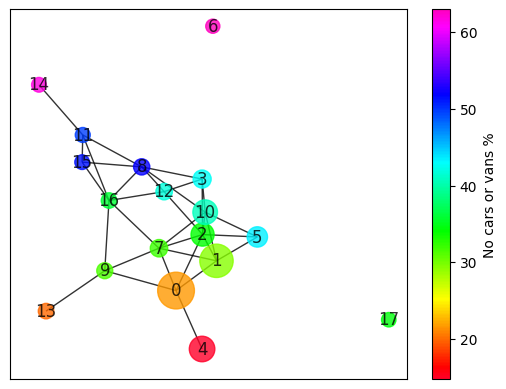

In [ ]:
cdf = pd.DataFrame(df1['no_cars_vansP'])

bm1=pbm.BallMapper(X=adf, eps=15, coloring_df=cdf)

bm1.draw_networkx(coloring_variable='no_cars_vansP', color_palette=hsvp, colorbar=True, colorbar_label="No cars or vans %", pos=nx.spring_layout(bm1.Graph, k=0.5, seed=1))

In the next part, combine the ball mapper with the map

In [ ]:
pb1 = bm1.points_and_balls()

In [ ]:
merged_allP['point'] = merged_allP.index
df1['point'] = df1.index

<ipython-input-101-6e8c76640f3e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['point'] = df1.index


In [ ]:
fulld = merged_allP.merge(pb1, on='point')
subd = df1.merge(pb1, on='point')

In [ ]:
ballslist = pd.DataFrame(fulld[["ball","wardcode","ward","dep_noneP"]])
ballslist.to_csv('balllistcl5.csv', index=False)

In [ ]:
dep_nonePm = subd.groupby('ball')['dep_noneP'].mean()
no_qualifPm = subd.groupby('ball')['no_qualifP'].mean()
level4_qualifPm = subd.groupby('ball')['level4_qualifP'].mean()
main_not_englishPm = subd.groupby('ball')['main_not_englishP'].mean()
dep_nonePm = subd.groupby('ball')['65_overP'].mean()
h_bad_verybadPm = subd.groupby('ball')['h_bad_verybadP'].mean()
no_cars_vansPm = subd.groupby('ball')['no_cars_vansP'].mean()



ballmeans = pd.DataFrame([dep_nonePm,no_qualifPm,level4_qualifPm,main_not_englishPm,dep_nonePm,h_bad_verybadPm,no_cars_vansPm])
ballmeans = ballmeans.transpose()

In [ ]:
lout = pd.DataFrame(columns=['outp'], index=range(ballmeans.shape[0]))

for i in range(ballmeans.shape[0]):
    lout.loc[i,'outp'] = ["&" + str(round(ballmeans.iloc[i,0],2))+"&" +  str(round(ballmeans.iloc[i,1],2)) + "&"  + str(round(ballmeans.iloc[i,2],2)) + "&"  + str(round(ballmeans.iloc[i,3],2))+ "&"  + str(round(ballmeans.iloc[i,4],2))+ "&"  + str(round(ballmeans.iloc[i,5],2))+ "&"  + str(round(ballmeans.iloc[i,6],2))]

lout.to_csv('ballmeanscl5.txt', sep='\t', index=False)

lout.head()

,outp
0,[&19.86&18.96&29.94&3.77&19.86&6.19&21.61]
1,[&16.78&23.91&24.08&5.82&16.78&7.58&29.41]
2,[&12.26&27.08&24.32&15.82&12.26&7.13&33.98]
3,[&9.54&30.38&23.41&25.09&9.54&7.25&42.76]
4,[&23.46&13.49&41.86&3.42&23.46&4.67&14.74]


**Mapping**

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
gb_shape = gpd.read_file('/content/WD_DEC_22_GB_BFC.shp')

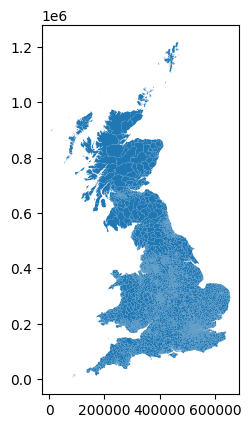

In [ ]:
gb_shape.plot(); plt.show()

In [ ]:
gb_shape.head()

,WD22CD,WD22NM,WD22NMW,LAD22CD,LAD22NM,BNG_E,BNG_N,LONG,LAT,Shape_Leng,GlobalID,geometry
0,E05000650,Astley Bridge,None,E08000001,Bolton,370670,412906,-2.44479,53.6119,15040.493581,7e82c1d4-0523-493e-abb8-736a20bbd587,"POLYGON ((370294.199 414678.699, 370300.399 41..."
1,E05000651,Bradshaw,None,E08000001,Bolton,374590,413058,-2.38555,53.6135,16910.442350,d8162450-182a-43fc-a0ee-0ca67e86cb17,"POLYGON ((375025.397 414992.099, 375032.702 41..."
2,E05000652,Breightmet,None,E08000001,Bolton,374437,409641,-2.38758,53.5827,10083.153424,3c6b769b-48c7-4427-aba5-4fc25bf2674a,"POLYGON ((375150.804 410809.796, 375151.101 41..."
3,E05000653,Bromley Cross,None,E08000001,Bolton,372113,414150,-2.42309,53.6231,16325.175894,799ef89f-a7e6-424c-b7fd-894fcdca4d01,"POLYGON ((373286.299 414364.499, 373289.267 41..."
4,E05000654,Crompton,None,E08000001,Bolton,371741,410493,-2.42838,53.5903,12524.442409,185575af-e414-4d13-a263-8926e9ffd626,"POLYGON ((373168.601 411597.801, 373160.900 41..."


In [ ]:
fulld['WD22CD'] = fulld['wardcode']

In [ ]:
gb_shape2=gb_shape.merge(fulld, on='WD22CD')

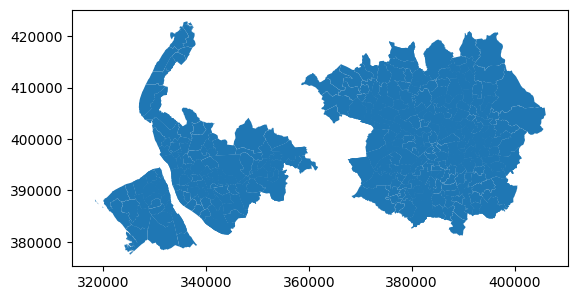

In [ ]:
gb_shape2.plot(); plt.show()

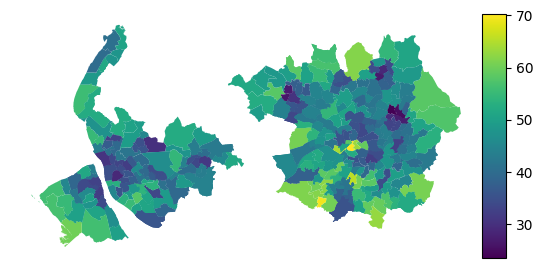

In [ ]:
fig, ax = plt.subplots(1,1)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%", pad=0.0)
gb_shape2.plot(column="dep_noneP",ax=ax,legend=True,cax=cax)
plt.show()

In [ ]:
fulld2 = gb_shape2.merge(pb1, on='point')

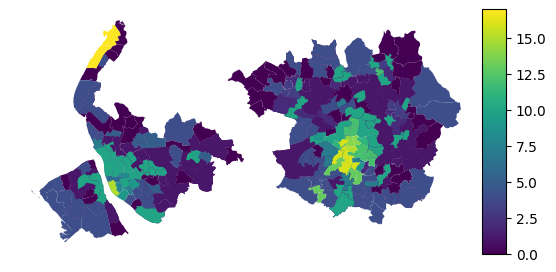

In [ ]:
fig, ax = plt.subplots(1,1)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%", pad=0.0)
gb_shape2.plot(column="ball",ax=ax,legend=True,cax=cax)
plt.show()

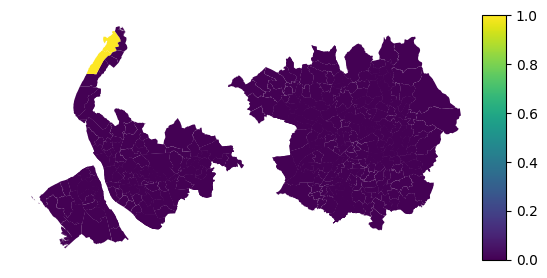

In [ ]:
gb_shape2['ball17'] = (gb_shape2['ball']==17)*1

fig, ax = plt.subplots(1,1)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%", pad=0.0)
gb_shape2.plot(column="ball17",ax=ax,legend=True,cax=cax)
plt.show()